IMPORTING RELEVANT LIBARIES 

In [30]:
import os
import cv2
import time
import numpy as np
import mediapipe as mp
import kerastuner as kt
from keras.optimizers import Adam
from keras.models import Sequential
from matplotlib import pyplot as plt
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten, TimeDistributed, Reshape


SETTING UP KEYPOINT FUNCTIONS USING MEDIAPIPE HOLISTIC TO EXTRACT VALUES FROM IMPORTANT FEATURES (HAND ,FACE,POSE)

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [5]:
def draw_styled_landmarks(image, results):
    # Draw face connections using FACEMESH_CONTOURS
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                              mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=1, circle_radius=1),
                              mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=1, circle_radius=1))

    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(80, 22, 10), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(80, 44, 121), thickness=2, circle_radius=2))

    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(121, 44, 250), thickness=2, circle_radius=2))

    # Draw right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2))


In [6]:
# Print the available attributes and methods in mp.solutions.holistic
print(dir(mp.solutions.holistic))

['FACEMESH_CONTOURS', 'FACEMESH_TESSELATION', 'HAND_CONNECTIONS', 'HandLandmark', 'Holistic', 'NamedTuple', 'POSE_CONNECTIONS', 'PoseLandmark', 'SolutionBase', '_BINARYPB_FILE_PATH', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_download_oss_pose_landmark_model', 'constant_side_packet_calculator_pb2', 'detections_to_rects_calculator_pb2', 'download_utils', 'gate_calculator_pb2', 'image_to_tensor_calculator_pb2', 'inference_calculator_pb2', 'landmark_projection_calculator_pb2', 'local_file_contents_calculator_pb2', 'non_max_suppression_calculator_pb2', 'np', 'rect_transformation_calculator_pb2', 'roi_tracking_calculator_pb2', 'split_vector_calculator_pb2', 'ssd_anchors_calculator_pb2', 'switch_container_pb2', 'tensors_to_classification_calculator_pb2', 'tensors_to_floats_calculator_pb2', 'tensors_to_landmarks_calculator_pb2']


In [7]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw  the landmarks
        draw_styled_landmarks(image, results)

        # Show display on the  screen
        cv2.imshow('OpenCV Feed', image)

        # Break
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [8]:
draw_styled_landmarks(image, results)

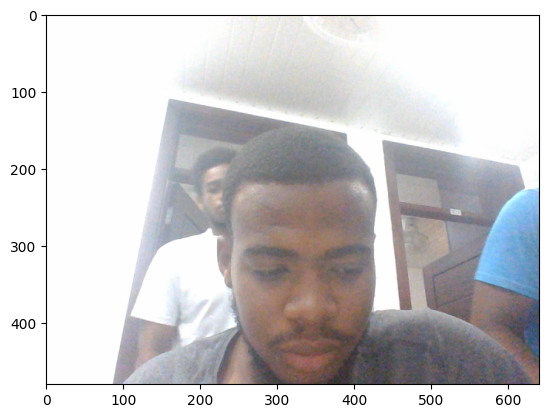

In [9]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

EXTRACTING KEY POINT VALUES 


In [10]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [11]:
pose = np.zeros(33*4)  # Placeholder for pose landmarks (33 landmarks with 4 values each)
face = np.zeros(468*3)  # Placeholder for face landmarks (468 landmarks with 3 values each)
lh = np.zeros(21*3)  # Placeholder for left hand landmarks (21 landmarks with 3 values each)
rh = np.zeros(21*3)  # Placeholder for right hand landmarks (21 landmarks with 3 values each)



In [12]:
if results.pose_landmarks:
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten()

if results.face_landmarks:
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten()

if results.left_hand_landmarks:
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten()

if results.right_hand_landmarks:
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten()


In [13]:

if results.face_landmarks:
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten()
face

array([ 5.39475322e-01,  8.92293334e-01, -1.89122744e-02, ...,
        6.40643954e-01,  6.78422630e-01, -1.43338475e-04])

In [14]:
def extract_keypoints(results):
    def flatten_landmarks(landmarks, num_landmarks, num_coords):
        return np.array([[res.x, res.y, res.z] for res in landmarks.landmark]).flatten() if landmarks else np.zeros(num_landmarks * num_coords)

    pose = flatten_landmarks(results.pose_landmarks, 33, 4)
    face = flatten_landmarks(results.face_landmarks, 468, 3)
    lh = flatten_landmarks(results.left_hand_landmarks, 21, 3)
    rh = flatten_landmarks(results.right_hand_landmarks, 21, 3)

    return np.concatenate([pose, face, lh, rh])


In [15]:
result_test = extract_keypoints(results)

In [16]:
result_test

array([ 0.52915072,  0.79940689, -1.84311748, ...,  0.        ,
        0.        ,  0.        ])

In [17]:
np.save('0', result_test)

In [18]:
np.load('0.npy')


array([ 0.52915072,  0.79940689, -1.84311748, ...,  0.        ,
        0.        ,  0.        ])

SETUP FOR FOLDERS

In [19]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('DATA') 

# Actions that we try to detect
actions = np.array(["Bath", "Call", "Food", "Give","Learn","Patience", "Thank you", "Hello"])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

In [20]:

# # Loop through each action
# for action in actions:
#     action_path = os.path.join(DATA_PATH, action)
    
#     # Check if the action directory exists
#     if os.path.exists(action_path):
#         # Get a list of subdirectories (sequences) within the action directory
#         subdirs = [d for d in os.listdir(action_path) if os.path.isdir(os.path.join(action_path, d))]
        
#         # Check if the subdirectory list is not empty
#         if subdirs:
#             # Find the maximum value among the subdirectory names and increment from there
#             dirmax = np.max(np.array(subdirs).astype(int))
#         else:
#             # If no subdirectories exist, start from 1
#             dirmax = 0
#     else:
#         # If the action directory doesn't exist, create it and start from 1
#         os.makedirs(action_path)
#         dirmax = 0


In [21]:

#     # Create directories for sequences
# for sequence in range(1, no_sequences + 1):
#         try:
#             os.makedirs(os.path.join(action_path, str(dirmax + sequence)))
#         except FileExistsError:
#             pass

COLLECT KEYPOINTS FOR TRAINING AND TESTING

In [22]:
# cap = cv2.VideoCapture(0)
# # Set mediapipe model 
# with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
#     # Loop through actions
#     for action in actions:
#         # Loop through sequences aka videos
#         for sequence in range(dirmax + 1, dirmax + 1 + no_sequences):
#             # Loop through video length aka sequence length
#             for frame_num in range(sequence_length):

#                 # Read feed
#                 ret, frame = cap.read()

#                 # Make detections
#                 image, results = mediapipe_detection(frame, holistic)

#                 # Draw landmarks
#                 draw_styled_landmarks(image, results)
                
#                 # Apply wait logic
#                 if frame_num == 0: 
#                     cv2.putText(image, 'STARTING COLLECTION', (120,200), 
#                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
#                     cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
#                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
#                     # Show to screen
#                     cv2.imshow('OpenCV Feed', image)
#                     cv2.waitKey(500)
#                 else: 
#                     cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
#                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
#                     # Show to screen
#                     cv2.imshow('OpenCV Feed', image)
                
#                 # Export keypoints
#                 keypoints = extract_keypoints(results)
#                 npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                
#                 # Create directories if they don't exist
#                 os.makedirs(os.path.dirname(npy_path), exist_ok=True)
                
#                 np.save(npy_path, keypoints)

#                 # Break gracefully
#                 if cv2.waitKey(30) & 0xFF == ord('q'):
#                     break
                    
#     cap.release()
#     cv2.destroyAllWindows()


PREPROCESSING DATA AND CREATING LABELS FOR SIGN LANGUAGE WORDS 

In [23]:
label_word= {label:num for num, label in enumerate(actions)}
label_word

sequences, labels = [], []
# Loop through each action
for action in os.listdir(DATA_PATH):
    action_path = os.path.join(DATA_PATH, action)
    
    # Loop through sequences
    for sequence in os.listdir(action_path):
        frame_sequence = []
        sequence_path = os.path.join(action_path, sequence)
        
        # Loop through frames in the sequence
        for frame_num in range(sequence_length):
            # Load keypoints for each frame
            keypoint_path = os.path.join(sequence_path, f"{frame_num}.npy")
            keypoint_data = np.load(keypoint_path)
            frame_sequence.append(keypoint_data)
        
        sequences.append(frame_sequence)
        labels.append(action)

In [24]:
label_word

{'Bath': 0,
 'Call': 1,
 'Food': 2,
 'Give': 3,
 'Learn': 4,
 'Patience': 5,
 'Thank you': 6,
 'Hello': 7}

In [25]:
np.array(sequences).shape

(240, 30, 1629)

In [26]:

# Convert sequences and labels to numpy arrays
X = np.array(sequences)
y = np.array(labels)


In [27]:
# Calculate mean and standard deviation for normalization
mean_keypoints = np.mean(X, axis=(0, 1))
std_keypoints = np.std(X, axis=(0, 1))

# Normalize keypoints
X_normalized = (X - mean_keypoints) / std_keypoints


In [28]:
X.shape

(240, 30, 1629)

In [31]:
# Encoding categorical labels into numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Convert numerical labels to categorical format
num_classes = len(np.unique(y_encoded))
y_categorical = to_categorical(y_encoded, num_classes=num_classes)

In [32]:
# Split data into train, validation, and test sets
# Here, 80% is for training, 10% for validation, and 10% for testing
X_train, X_temp, y_train, y_temp = train_test_split(X_normalized, y_categorical, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [33]:
X_val_normalized = (X_val - mean_keypoints) / std_keypoints
X_test_normalized = (X_test - mean_keypoints) / std_keypoints

In [34]:
y_test.shape

(24, 8)

TRAINING AND TESTING 

In [35]:
# Define the model architecture
ASL = Sequential()

# CNN layer to extract spatial features from the keypoint data
ASL.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(30, 1629)))
ASL.add(MaxPooling1D(pool_size=2))

# LSTM layer to capture temporal dependencies between frames
ASL.add(LSTM(units=128, return_sequences=True))
ASL.add(LSTM(units=64))

# Flatten the output of the LSTM layer and pass it to a dense layer for classification
ASL.add(Flatten())
ASL.add(Dense(units=num_classes, activation='softmax'))

# Compile the model
ASL.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [36]:

# Train the model
ASL.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/100


6/6 [==============================] - 10s 413ms/step - loss: 1.6111 - accuracy: 0.4896 - val_loss: 1.1105 - val_accuracy: 0.7917
Epoch 2/100
6/6 [==============================] - 0s 32ms/step - loss: 0.8207 - accuracy: 0.8906 - val_loss: 0.6208 - val_accuracy: 0.8333
Epoch 3/100
6/6 [==============================] - 0s 41ms/step - loss: 0.3557 - accuracy: 0.9635 - val_loss: 0.3344 - val_accuracy: 0.9167
Epoch 4/100
6/6 [==============================] - 0s 36ms/step - loss: 0.1653 - accuracy: 0.9792 - val_loss: 0.1679 - val_accuracy: 0.9583
Epoch 5/100
6/6 [==============================] - 0s 44ms/step - loss: 0.0781 - accuracy: 0.9896 - val_loss: 0.1400 - val_accuracy: 0.9583
Epoch 6/100
6/6 [==============================] - 0s 37ms/step - loss: 0.0500 - accuracy: 1.0000 - val_loss: 0.1304 - val_accuracy: 0.9583
Epoch 7/100
6/6 [==============================] - 0s 41ms/step - loss: 0.0393 - accuracy: 0.9896 - val_loss: 0.1387 - val_accuracy: 0.9583
Epoch 8/100
6/6 

In [37]:
 #Save the trained model to a file
ASL.save('ASL.h5')

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [38]:
# After fitting the label encoder
label_encoder.fit(y)

# Save the label encoder
np.save('label_encoder.npy', label_encoder.classes_)

In [44]:
ASL.load_weights('sign.h5')

In [40]:
# Define colors
colors = [(245,117,16), (117,245,16), (16,117,245)]

def prob_viz(res, actions, input_frame, colors, max_actions=3):
    image = input_frame.copy()  # Copy the input frame
    for num, prob in enumerate(res[:max_actions]):  # Limit iteration to `max_actions`
        if 0 <= prob < len(actions):  # Check if `prob` is within the range of the `actions` list
            cv2.rectangle(image, (0, 60 + num * 40), (int(prob * 100), 90 + num * 40), colors[num], -1)
            cv2.putText(image, actions[num], (0, 85 + num * 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    return image


In [53]:

# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = ASL.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz pQrobabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti